In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import os

In [2]:
def preprocessing_data(data):
    # Filter for only Florida data
    data = data[data['state'] == 'Florida']

    data = data.drop(['prev_sold_date'], axis=1)

    # Convert categorical columns to numeric codes
    categorical_columns = ['status', 'city', 'state']
    for column in categorical_columns:
        data[column] = data[column].astype('category').cat.codes

    # Remove rows with NaN or infinite values in 'price'
    data = data.dropna(subset=['price'])
    data = data[np.isfinite(data['price'])]

    data = data[(data['price'] >= 500) ]
    data['price'] += 1

    # Log-transforming the price 
    data['log_price'] = np.log(data['price']) 

    for i in data.columns:
        data = data[np.isfinite(data[i])]
        
    return data

In [ ]:
def neg_log_error(model, X, y):
    y_pred = model.predict(X)
    log_error = np.abs(y - y_pred).mean()
    return -log_error


def ridge_regression(data, geospatial_data):
    warnings.filterwarnings("ignore")
    def neg_log_error(model, X, y):
        y_pred = model.predict(X)
        log_error = np.abs(y - y_pred).mean()
        return -log_error

    if type(geospatial_data) == type(data):
        data = pd.merge(data,geospatial_data, on='zip_code', how='left')
        
    features_to_drop = ['price', 'log_price']
    X = data.drop(features_to_drop, axis=1)
    y = data['log_price']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Ridge regression with cross-validation
    ridge_model = Ridge(alpha=1.0, random_state=42)  # You can adjust the alpha value as needed
    ridge_cv_scores = cross_val_score(ridge_model, X_train, y_train, cv=5, scoring=neg_log_error)

    ridge_model.fit(X_train, y_train)
    y_preds = ridge_model.predict(X_test)

    # evaluation metrics 
    mse = mean_squared_error(y_test, y_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_preds)

    # Print evaluation metrics
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R-squared (R2):", r2)

    # feature importance
    ridge_model.fit(X_train, y_train)
    feature_importance = np.abs(ridge_model.coef_)
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important features at the top
    plt.show()

    # Plotting the results
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test, y_preds, alpha=0.4)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Measured Log-Scaled Prices')
    plt.ylabel('Predicted Log-Scaled Prices')
    plt.title('Measured vs Predicted Log-Scaled Prices')
    plt.show()
    

In [3]:
def XGBOOST_Algorithm(data,geospatial_data):

    data = preprocessing_data(data)
        
    if type(geospatial_data) == type(data):
        data = pd.merge(data,geospatial_data, on='zip_code', how='left')

    # features_to_drop = ['brokered_by','status', 'street', 'zip_code','price','log_price']
    features_to_drop = ['price','log_price']
    X = data.drop(features_to_drop, axis=1)
    y = data['log_price']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # for i in range(1):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # XGBoost parameters
    params = {
        'objective': 'reg:squaredlogerror',
        'colsample_bytree': 0.2,
        'learning_rate': 1,
        'max_depth': 100,
        'alpha': 0
    }

    # Cross-validation
    cv_results = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=100,
        nfold=5,
        metrics={'rmsle'},
        early_stopping_rounds=20,
        as_pandas=True,
        seed=42,
    )

    # Plotting RMSE convergence over boosting rounds
    plt.figure(figsize=(10, 5))
    plt.plot(cv_results['train-rmsle-mean'], label='Train RMSLE')
    plt.plot(cv_results['test-rmsle-mean'], label='Test RMSLE')
    plt.title('RMSLE Over Boosting Rounds')
    plt.xlabel('Number of Boosting Rounds')
    plt.ylabel('RMSLE')
    plt.legend()
    plt.show()

    # Training the model on the full training set using optimal number of boosting rounds
    num_boost_rounds = cv_results.shape[0]
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_boost_rounds
    )

    # Feature importance
    xgb.plot_importance(model, max_num_features=10, importance_type='weight', title='Feature Importance')
    plt.show()

    # Predictions on the test set
    y_pred = model.predict(dtest)

    # Evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"RMSLE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R-squared: {r2}")

    # Plotting the results
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test, y_pred,alpha=0.4)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Measured Log-Scaled Prices')
    plt.ylabel('Predicted Log-Scaled Prices')
    plt.title('Measured vs Predicted Log-Scaled Prices')
    plt.show()
    

Results for XGBOOST----------------------------------------------------------------START----------------------------------------------------------------------------------


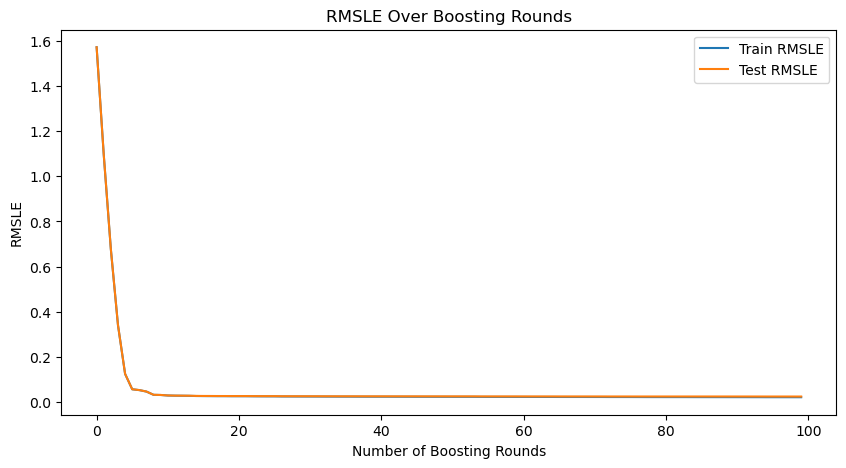

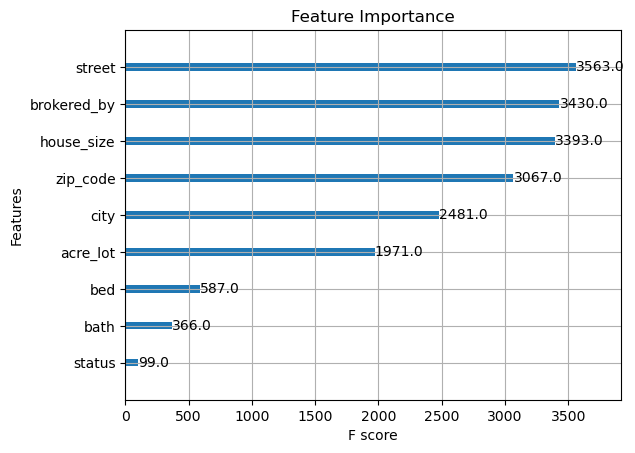

RMSLE: 0.32580456667184027
MAE: 0.22822821669926982
R-squared: 0.8212831687970882


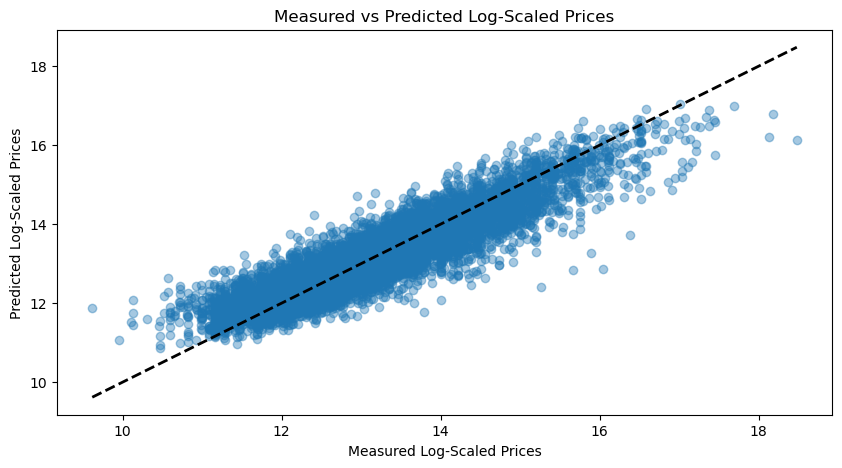

Results for XGBOOST-----------------------------------------------------------------END----------------------------------------------------------------------------------


In [4]:
data = pd.read_csv('Data/usa_real_estate_dataset.csv')
print("Results for Ridge Regression----------------------------------------------------------------START----------------------------------------------------------------------------------")
ridge_regression(data,geospatial_data=None)
print("Results for Ridge Regression-----------------------------------------------------------------END----------------------------------------------------------------------------------")

print("Results for XGBOOST----------------------------------------------------------------START----------------------------------------------------------------------------------")
XGBOOST_Algorithm(data,geospatial_data=None)
print("Results for XGBOOST-----------------------------------------------------------------END----------------------------------------------------------------------------------")

Results for XGBOOST with geospatial data----------------------------------------------------------------START----------------------------------------------------------------------------------


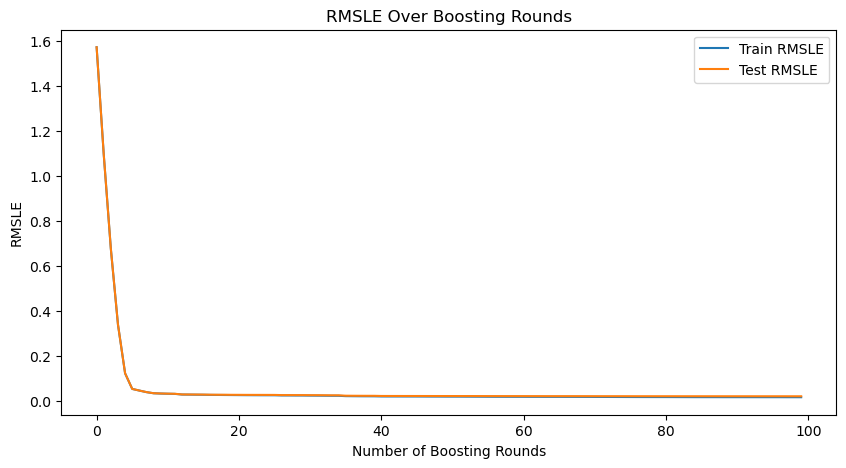

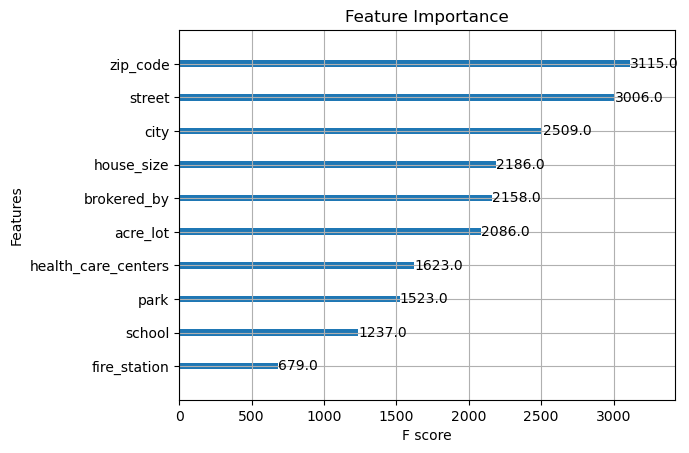

RMSLE: 0.30229300074518023
MAE: 0.21391121800333426
R-squared: 0.8461465270266001


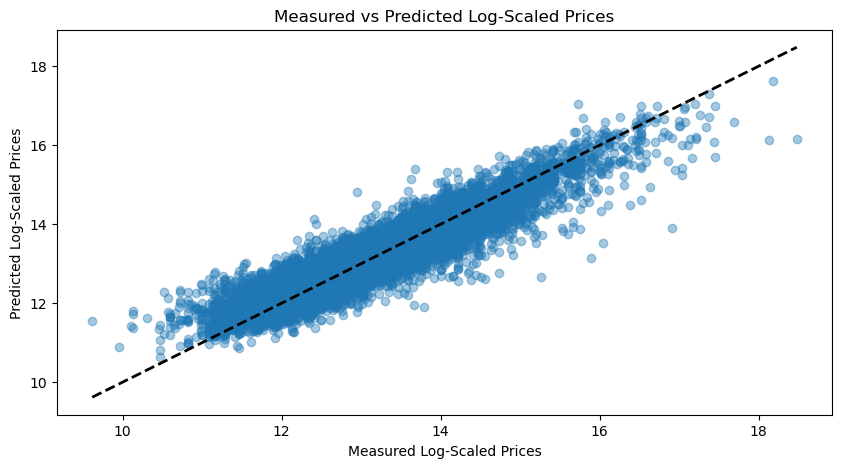

Results for XGBOOST with geospatial data-----------------------------------------------------------------End----------------------------------------------------------------------------------


In [5]:
#extracting Geospatial Data
type_zipcode_counts = pd.DataFrame(columns=['Zipcode'])

folder_path = r".\Data\Census"
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        data = pd.read_csv(file_path)
        data = data.dropna(subset=['zipcode'])
        file_type = data['type'].unique()[0]
        counts = data.groupby('zipcode').size() 
        counts.name = file_type 
        type_zipcode_counts = pd.merge(type_zipcode_counts, counts, left_on='Zipcode', right_index=True, how='outer')
        
type_zipcode_counts.fillna(0, inplace=True)
type_zipcode_counts.rename(columns={'Zipcode': 'zip_code'}, inplace=True)

data = pd.read_csv('Data/usa_real_estate_dataset.csv')



print("Results for Ridge Regression----------------------------------------------------------------START----------------------------------------------------------------------------------")
ridge_regression(data,geospatial_data = type_zipcode_counts)
print("Results for Ridge Regression-----------------------------------------------------------------END----------------------------------------------------------------------------------")

print("Results for XGBOOST with geospatial data----------------------------------------------------------------START----------------------------------------------------------------------------------")
XGBOOST_Algorithm(data,geospatial_data= type_zipcode_counts)
print("Results for XGBOOST with geospatial data-----------------------------------------------------------------End----------------------------------------------------------------------------------")